Ingrese el porcentaje de contaminación (por ejemplo, 0.05 para 5%): 0.05


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


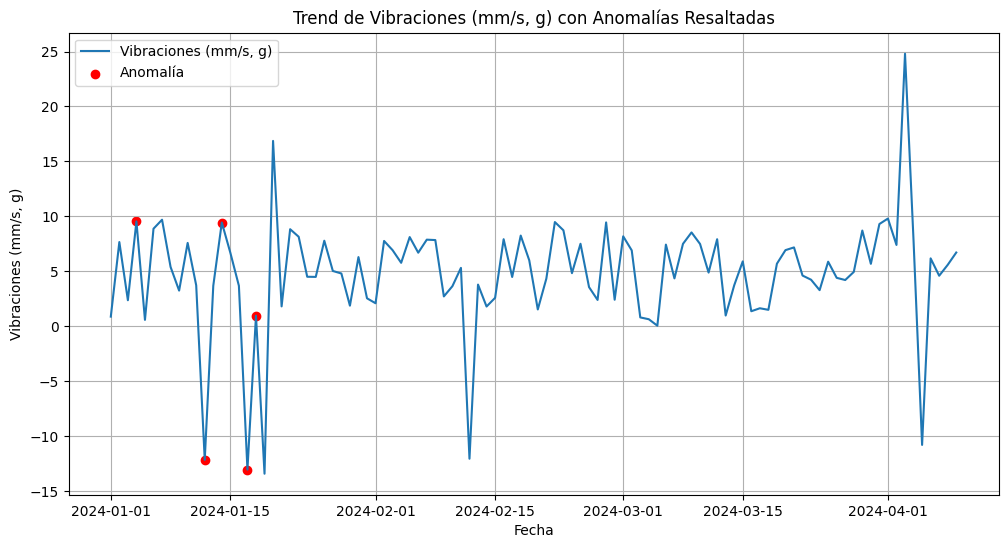

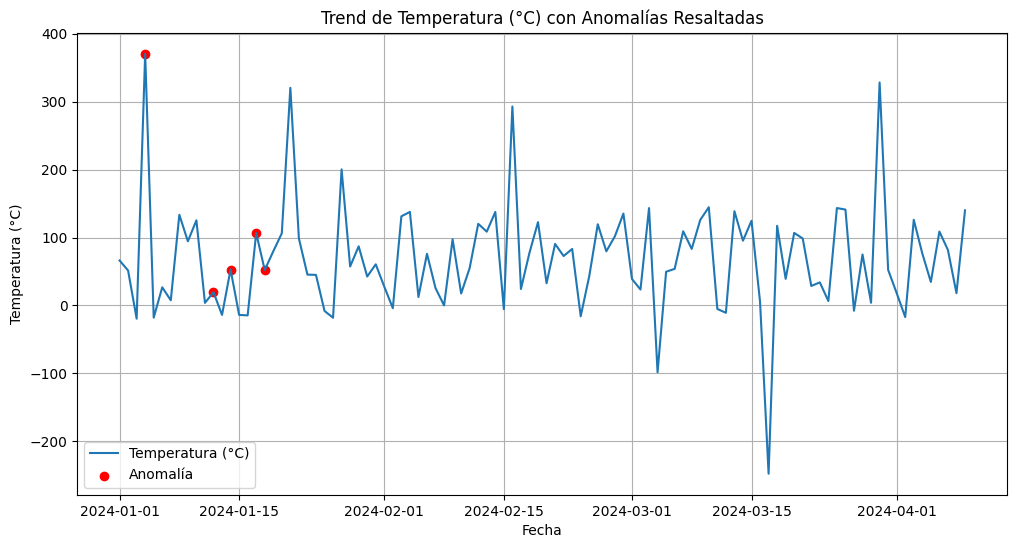

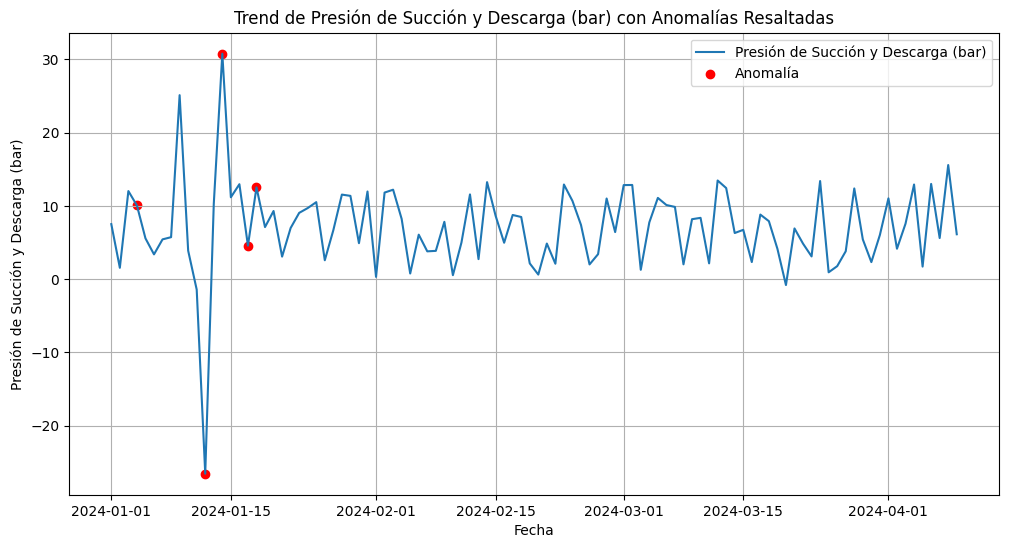

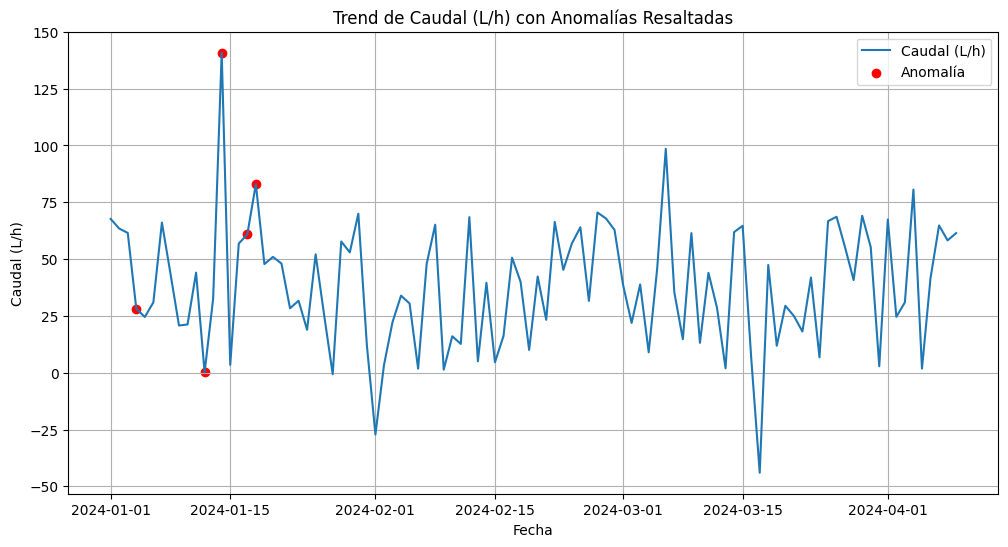

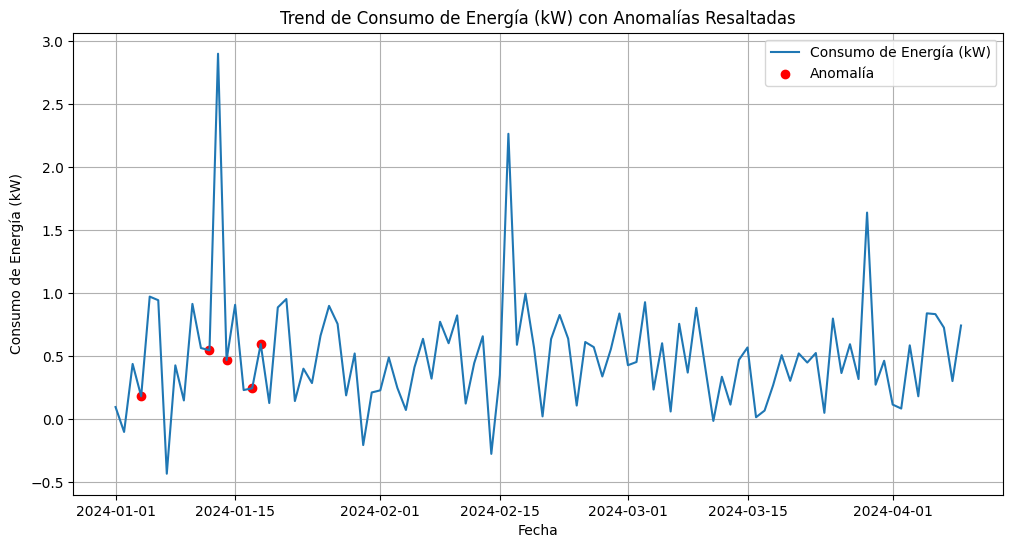

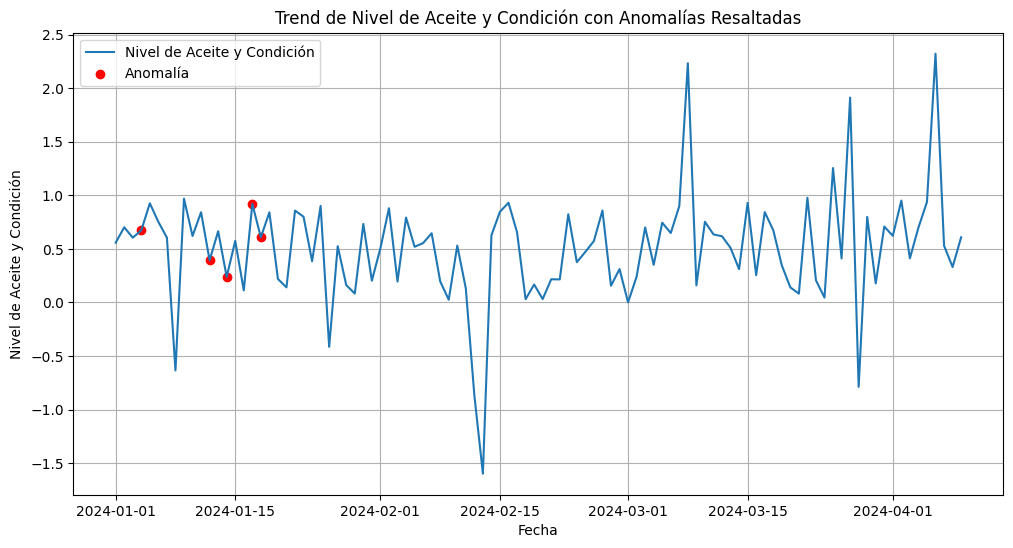

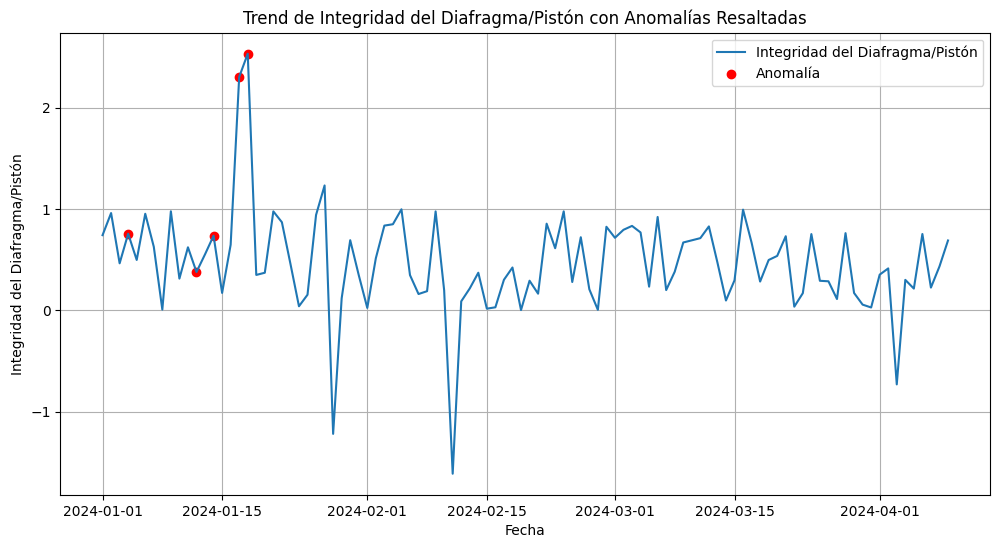

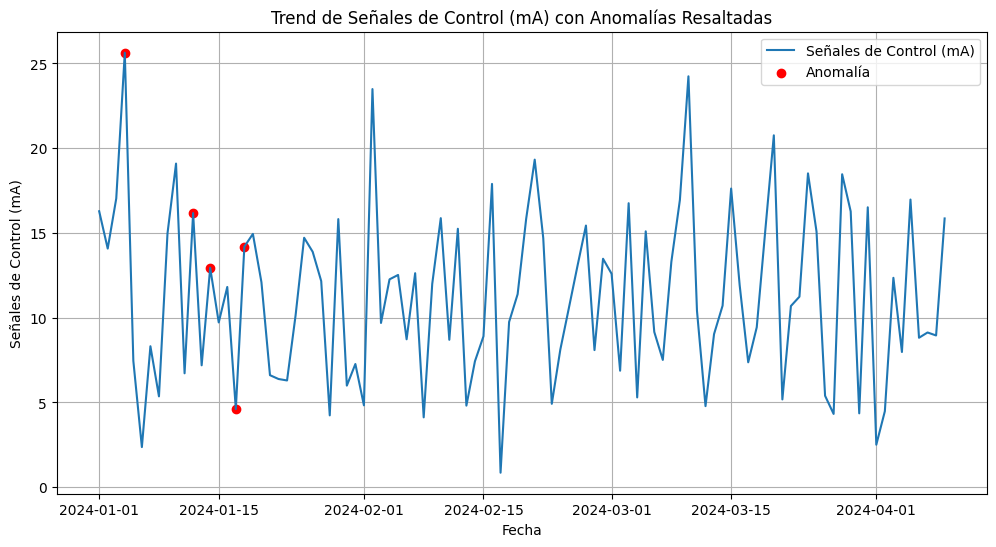

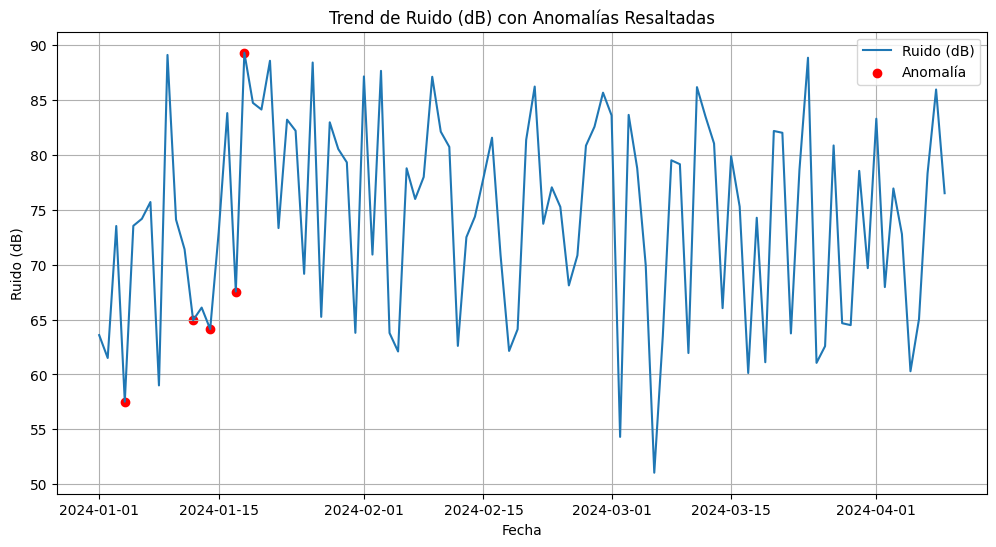

Ingrese la fecha de inicio (formato YYYY-MM-DD): 2024-03-01
Ingrese la fecha de fin (formato YYYY-MM-DD): 2024-03-30


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
<ipython-input-25-5c81170ad9d1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Anomalía'] = model.fit_predict(df[columnas])
<ipython-input-25-5c81170ad9d1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Anomalía'] = df['Anomalía'].map({1: 0, -1: 1})


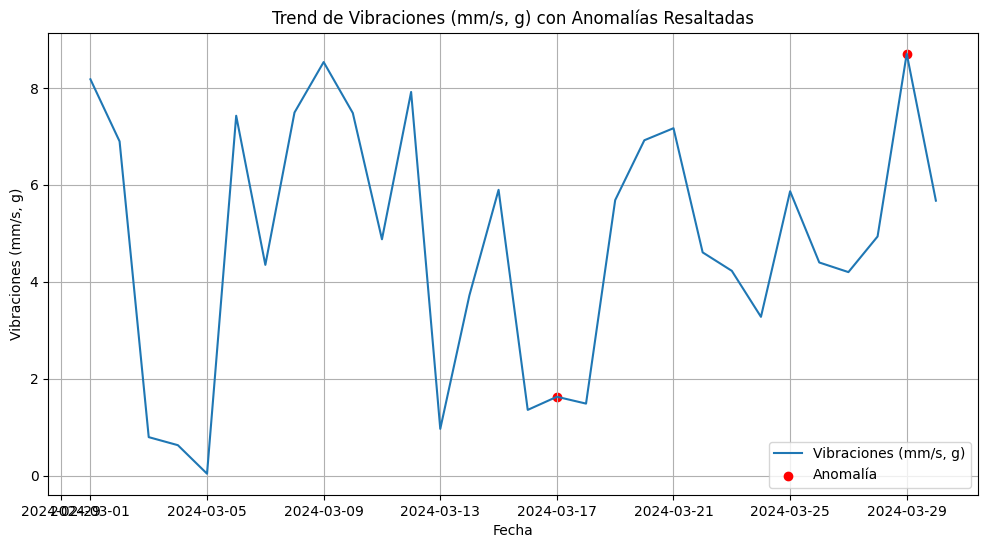

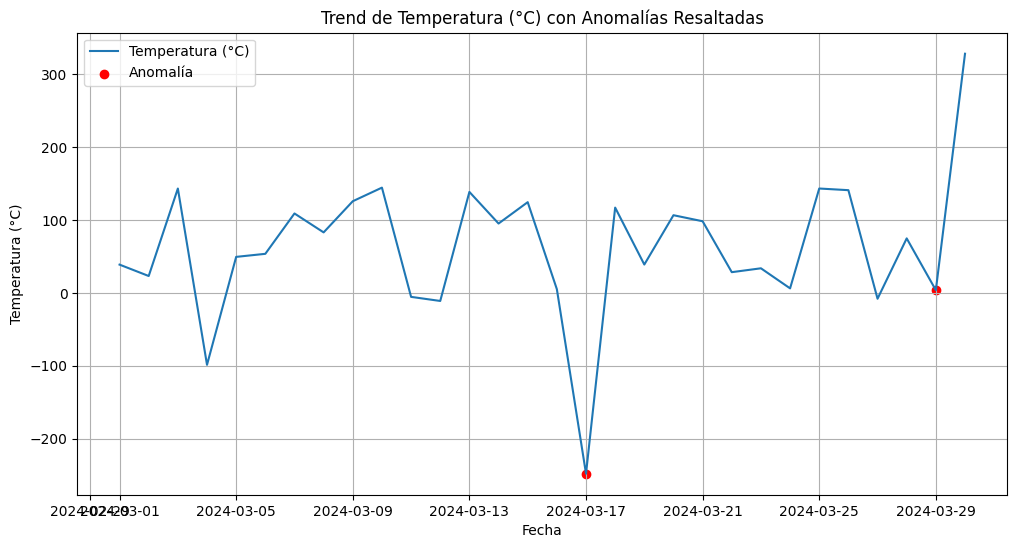

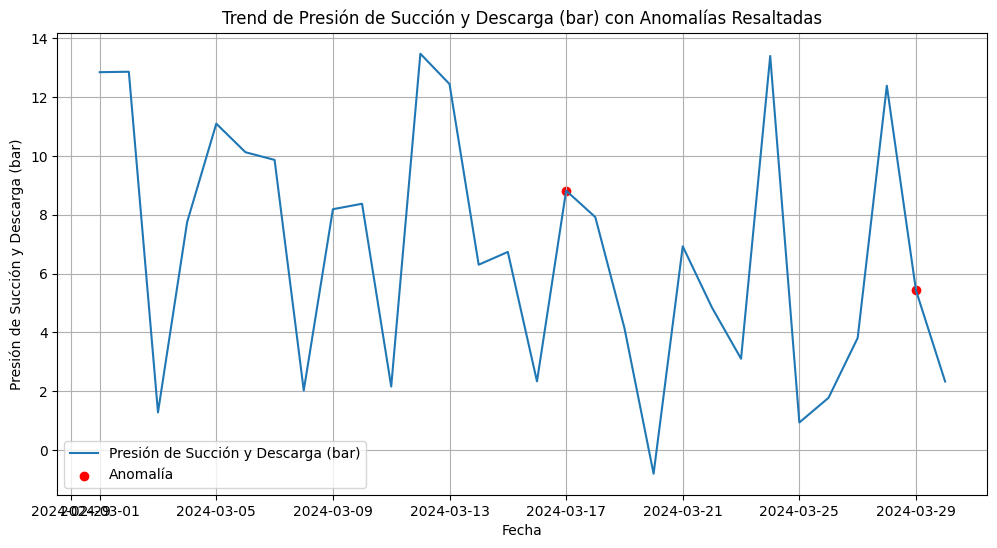

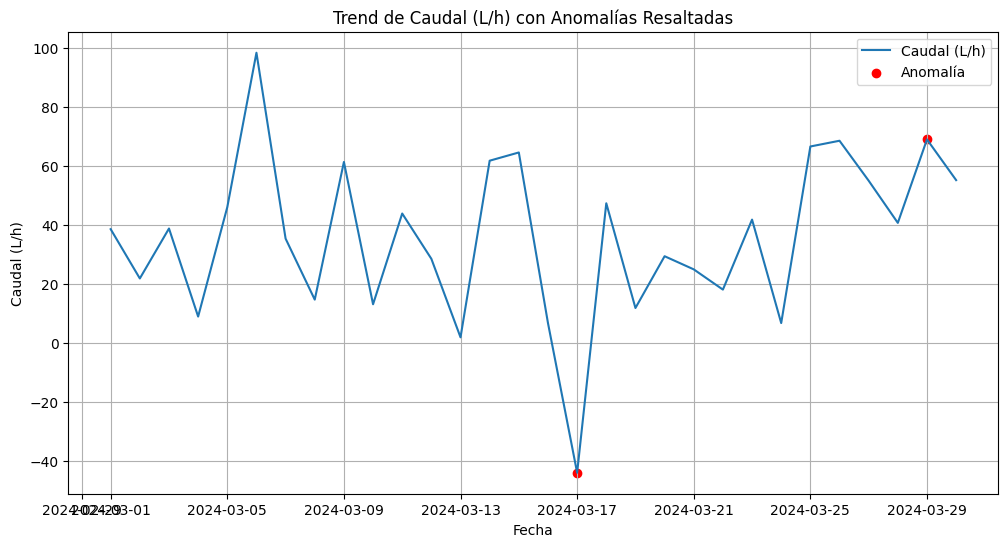

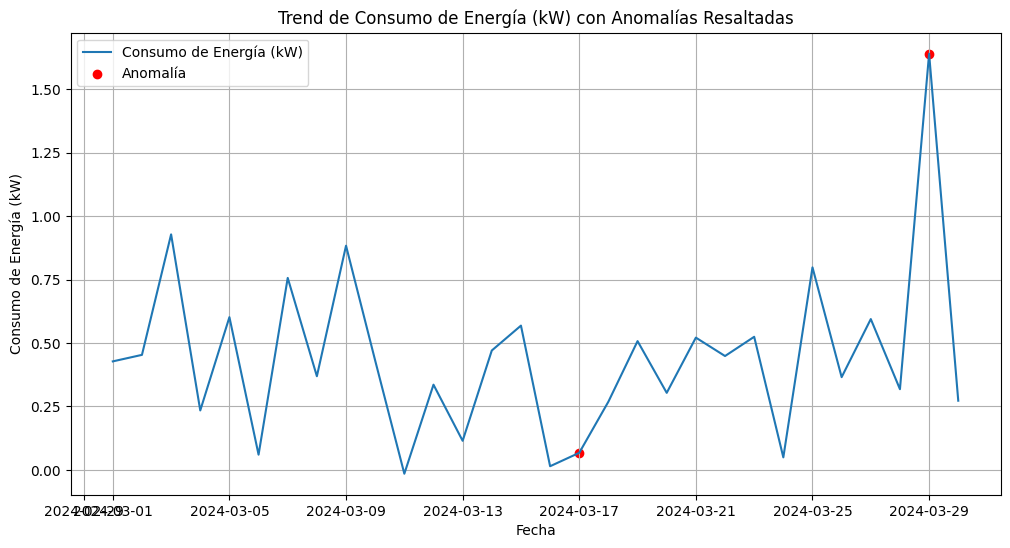

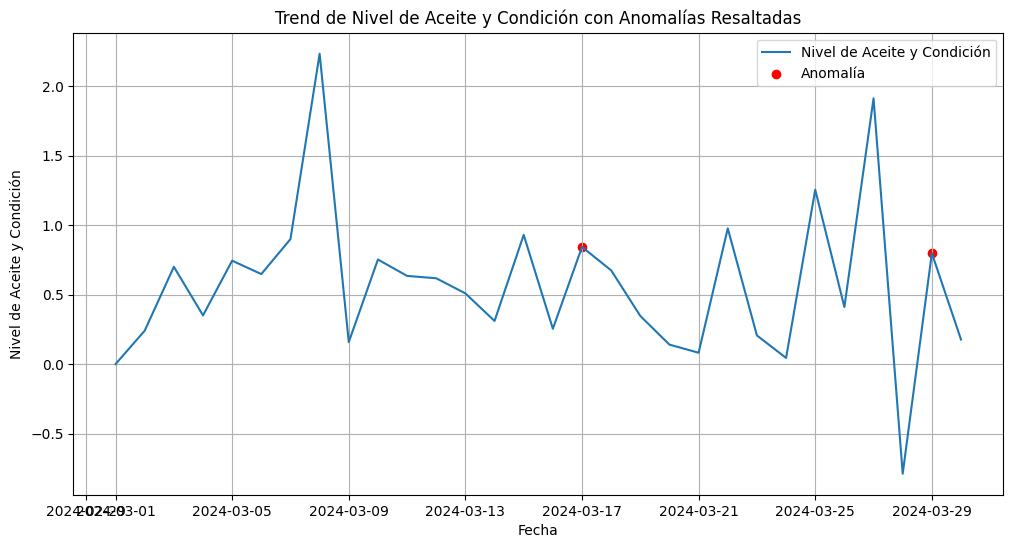

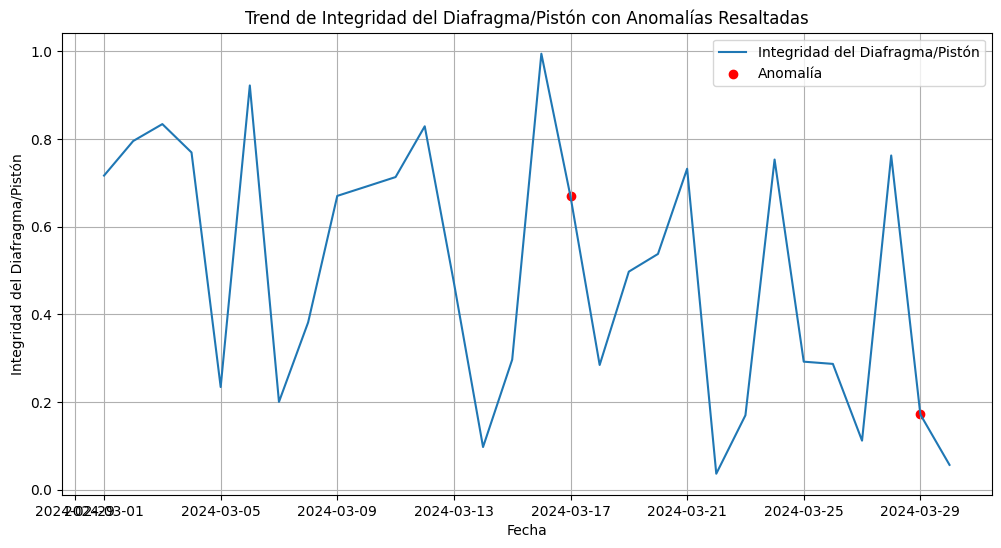

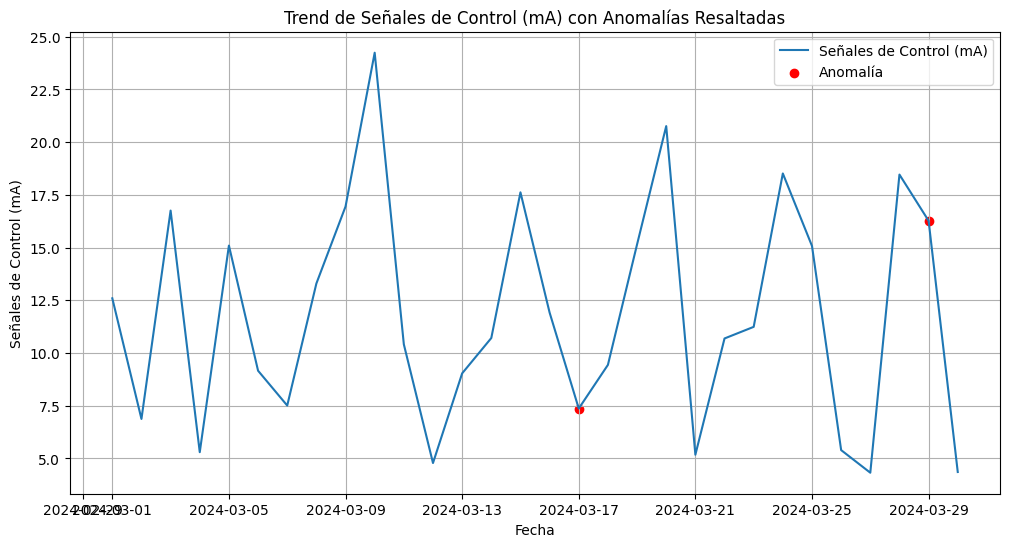

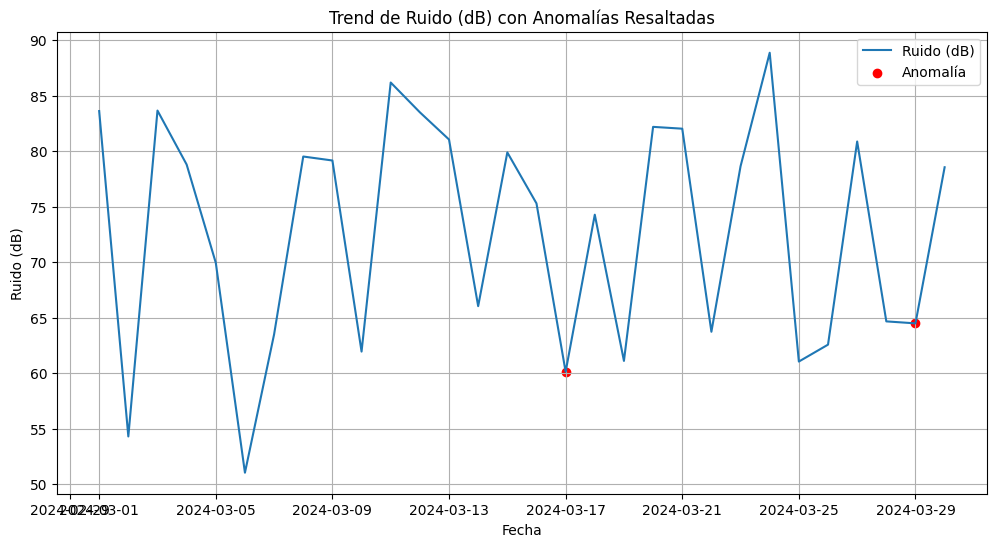

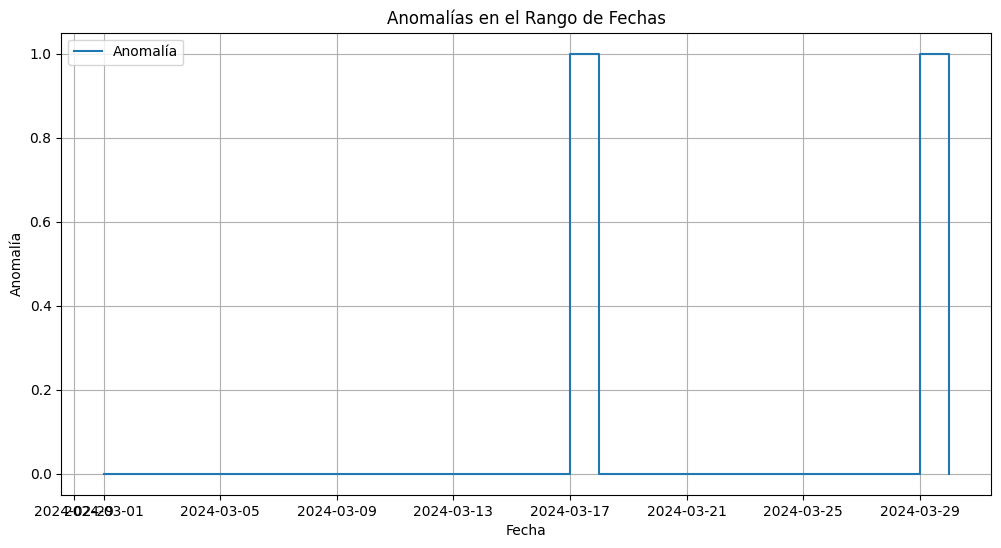

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# Instalación de bibliotecas necesarias
!pip install pandas matplotlib numpy openpyxl scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from matplotlib.backends.backend_pdf import PdfPages
import textwrap

# Función para detectar anomalías usando Isolation Forest
def detectar_anomalias_isolation_forest(df, columnas, contamination):
    model = IsolationForest(contamination=contamination, random_state=42)
    df['Anomalía'] = model.fit_predict(df[columnas])
    df['Anomalía'] = df['Anomalía'].map({1: 0, -1: 1})
    return df

# Función para plotear los datos y resaltar anomalías
def plot_trends(df, columnas, pdf=None):
    for col in columnas:
        plt.figure(figsize=(12, 6))
        plt.plot(df["Fecha"], df[col], label=col)
        anomalous_points = df[df['Anomalía'] == 1].index
        plt.scatter(df["Fecha"][anomalous_points], df[col][anomalous_points], color='red', label='Anomalía')
        plt.xlabel('Fecha')
        plt.ylabel(col)
        plt.title(f'Trend de {col} con Anomalías Resaltadas')
        plt.legend()
        plt.grid(True)
        if pdf:
            pdf.savefig()
        plt.show()

# Función para generar recomendaciones basadas en modos de falla
def generar_recomendaciones(df, descripciones, tiempo_establecido, pdf=None):
    recomendaciones = {}
    for col in descripciones.keys():
        fechas_anomalias = df["Fecha"][df["Anomalía"] == 1].tolist()
        valores_anomalias = df[col][df["Anomalía"] == 1].tolist()
        if (df["Anomalía"] == 1).any():
            recomendaciones[col] = {
                "descripcion": descripciones[col],
                "frecuencia": len(fechas_anomalias),
                "fechas": fechas_anomalias,
                "valores": valores_anomalias
            }

    recomendacion_text = f"Recomendaciones para realizar en los próximos {tiempo_establecido} días:\n"
    table_data = [["Parámetro", "Descripción", "Frecuencia", "Fechas de Anomalía", "Valores de Anomalía"]]
    for parametro, detalle in recomendaciones.items():
        wrapped_desc = '\n'.join(textwrap.wrap(detalle['descripcion'], width=30))
        wrapped_fechas = '\n'.join(textwrap.wrap(', '.join([str(fecha) for fecha in detalle['fechas']]), width=20))
        wrapped_valores = '\n'.join(textwrap.wrap(', '.join([str(valor) for valor in detalle['valores']]), width=20))
        table_data.append([
            parametro,
            wrapped_desc,
            detalle['frecuencia'],
            wrapped_fechas,
            wrapped_valores
        ])

    if pdf:
        plt.figure(figsize=(12, 6))
        plt.axis('tight')
        plt.axis('off')
        colWidths = [0.15, 0.4, 0.1, 0.2, 0.25]  # Ajuste de los anchos de las columnas
        table = plt.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center', colWidths=colWidths)
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.2, 3.6)  # Aumentar la altura de las filas al triple
        pdf.savefig()
        plt.close()

# Función para plotear la gráfica de anomalías en el rango de fechas
def plot_anomalias_rango(df, pdf=None):
    plt.figure(figsize=(12, 6))
    plt.plot(df["Fecha"], df['Anomalía'], label='Anomalía', drawstyle='steps-post')
    plt.xlabel('Fecha')
    plt.ylabel('Anomalía')
    plt.title('Anomalías en el Rango de Fechas')
    plt.legend()
    plt.grid(True)
    if pdf:
        pdf.savefig()
    plt.show()

# Función para retroalimentar el modelo
def retroalimentar_modelo(df, descripciones):
    for col in descripciones.keys():
        fechas_anomalias = df["Fecha"][df["Anomalía"] == 1].tolist()
        if fechas_anomalias:
            respuesta_anomalia = input(f"¿Ocurrió una anomalía en las fechas detectadas para {col}? (SÍ/NO): ")
            if respuesta_anomalia.upper() == "NO":
                print("Terminando el código.")
                return False
            elif respuesta_anomalia.upper() == "SÍ":
                respuesta_modo_falla = input(f"¿Ocurrió el modo de falla '{descripciones[col]}' en las fechas detectadas? (SÍ/NO): ")
                if respuesta_modo_falla.upper() == "SÍ":
                    # Aquí podríamos retroalimentar el modelo. En este ejemplo, solo imprimimos la respuesta.
                    print(f"Retroalimentación recibida: El modo de falla '{descripciones[col]}' ocurrió.")
    return True

# Definir los parámetros de monitoreo
parametros = [
    "Vibraciones (mm/s, g)", "Temperatura (°C)", "Presión de Succión y Descarga (bar)",
    "Caudal (L/h)", "Consumo de Energía (kW)", "Nivel de Aceite y Condición",
    "Integridad del Diafragma/Pistón", "Señales de Control (mA)", "Ruido (dB)"
]

# Definir los umbrales para cada parámetro
umbrales = {
    "Vibraciones (mm/s, g)": (0, 10),
    "Temperatura (°C)": (-20, 150),
    "Presión de Succión y Descarga (bar)": (0, 14),
    "Caudal (L/h)": (0, 70.8),
    "Consumo de Energía (kW)": (0, 1),
    "Nivel de Aceite y Condición": (0, 1),
    "Integridad del Diafragma/Pistón": (0, 1),
    "Señales de Control (mA)": (4, 20),
    "Ruido (dB)": (60, 90)
}

# Definir las descripciones de los modos de falla
descripciones_falla = {
    "Vibraciones (mm/s, g)": "Desbalance del motor o acoplamiento, desgaste o daño en los cojinetes, problemas en la caja de engranajes.",
    "Temperatura (°C)": "Sobrecalentamiento del motor, falla en la lubricación, condiciones ambientales extremas.",
    "Presión de Succión y Descarga (bar)": "Obstrucción en las líneas de succión o descarga, fugas en las válvulas de retención, desgaste del pistón o diafragma.",
    "Caudal (L/h)": "Obstrucción en las líneas de succión o descarga, desgaste o daño en el pistón/diafragma, ajuste incorrecto de dosificación.",
    "Consumo de Energía (kW)": "Sobrecarga del motor, desgaste de componentes internos, problemas en el suministro eléctrico.",
    "Nivel de Aceite y Condición": "Falta de lubricación, contaminación del aceite.",
    "Integridad del Diafragma/Pistón": "Desgaste o ruptura del diafragma/pistón, fugas internas.",
    "Señales de Control (mA)": "Problemas en el actuador eléctrico, fallas en el sistema de control.",
    "Ruido (dB)": "Desgaste de componentes internos, problemas en la alineación."
}

# Cargar datos desde el archivo Excel
file_path = "/content/CBM_Parametros_Bomba_Dosificacion_Anomalias.xlsx"  # Ajustar según sea necesario
df_valores = pd.read_excel(file_path)

# Convertir la columna de fecha a tipo datetime
# Intentar varias posibles columnas para la fecha
fecha_col = None
for col in df_valores.columns:
    try:
        df_valores[col] = pd.to_datetime(df_valores[col])
        fecha_col = col
        break
    except ValueError:
        continue

if fecha_col is None:
    raise ValueError("No se encontró una columna de fecha válida en el archivo Excel.")

df_valores.rename(columns={fecha_col: "Fecha"}, inplace=True)

# Solicitar al usuario ingresar el porcentaje de contaminación
contamination_percentage = float(input("Ingrese el porcentaje de contaminación (por ejemplo, 0.05 para 5%): "))

# Detectar anomalías usando Isolation Forest con el porcentaje de contaminación ingresado
df_valores = detectar_anomalias_isolation_forest(df_valores, parametros, contamination_percentage)

# Crear un archivo PDF para guardar las gráficas
pdf_path = "/content/Anomalias_Bomba_Dosificacion.pdf"
with PdfPages(pdf_path) as pdf:
    # Plotear los datos con anomalías resaltadas y guardarlos en el PDF
    plot_trends(df_valores, parametros, pdf)

    # Generar recomendaciones basadas en modos de falla
    generar_recomendaciones(df_valores, descripciones_falla, tiempo_establecido=30, pdf=pdf)

    # Análisis en un rango de fechas específico
    def analizar_rango_fechas(df, fecha_inicio, fecha_fin):
        df_rango = df[(df["Fecha"] >= fecha_inicio) & (df["Fecha"] <= fecha_fin)]
        df_rango = detectar_anomalias_isolation_forest(df_rango, parametros, contamination_percentage)
        plot_trends(df_rango, parametros, pdf)
        plot_anomalias_rango(df_rango, pdf)
        generar_recomendaciones(df_rango, descripciones_falla, tiempo_establecido=30, pdf=pdf)

    # Solicitar al usuario ingresar las fechas a analizar
    fecha_inicio = input("Ingrese la fecha de inicio (formato YYYY-MM-DD): ")
    fecha_fin = input("Ingrese la fecha de fin (formato YYYY-MM-DD): ")

    # Convertir las fechas ingresadas a tipo datetime
    fecha_inicio = pd.to_datetime(fecha_inicio)
    fecha_fin = pd.to_datetime(fecha_fin)

    # Analizar el rango de fechas especificado
    analizar_rango_fechas(df_valores, fecha_inicio, fecha_fin)

# Descargar el archivo PDF generado
from google.colab import files
files.download(pdf_path)
